In [90]:
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import feature_extraction as fx
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np




filename = 'dataset_adapted_pca.csv' # Mix 50% normal and 50% anomaly

In [91]:
model = anomaly.OneClassSVM(nu=0.5)

In [92]:
# List of columns to keep
dataset = pd.read_csv(filename, index_col=False)


# Divide dataset into train and test
# Obtain 10000 samples for training that contains benign samples remove from the dataset
# Select first 10000 rows where 'Label' is 0
dataset_train = dataset.loc[dataset['Label'] == 0].iloc[:5000]

# Drop these rows from the original dataset
dataset_test = dataset.drop(dataset_train.index)

print("Number of elements in the training dataset: ", len(dataset_train))
print("Number of elements in the test dataset: ", len(dataset_test))
print("\tBenign samples: ", len(dataset_test.loc[dataset['Label'] == 0]))
print("\tAnomaly samples: ", len(dataset_test.loc[dataset['Label'] == 1]))

# Shuffle dataset_test
dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)

# Separate the label
dataset_train_no_labels = dataset_train.drop(columns=['Label'])
dataset_test_no_labels = dataset_test.drop(columns=['Label'])

Number of elements in the training dataset:  5000
Number of elements in the test dataset:  5006
	Benign samples:  2500
	Anomaly samples:  2506


In [93]:
# Traning phase
scores_training = []

# Create a list of scores
for i, row in dataset_train_no_labels.iterrows():
    model.learn_one(row.to_dict())
    scores_training.append(model.score_one(row.to_dict()))  
    
print("Traning phase completed")


Traning phase completed


In [94]:
# Caracteristicas de los scores de la fase de entrenamiento
media_train = np.mean(scores_training)
print("Media de los scores de la fase de entrenamiento: ", media_train)
desviacion_estandar = np.std(scores_training)
print("Desviación estándar de los scores de la fase de entrenamiento: ", desviacion_estandar)
print("Máximo de los scores de la fase de entrenamiento: ", np.max(scores_training))
print("Mínimo de los scores de la fase de entrenamiento: ", np.min(scores_training))

Media de los scores de la fase de entrenamiento:  2.0569824926429146
Desviación estándar de los scores de la fase de entrenamiento:  70.20832184954004
Máximo de los scores de la fase de entrenamiento:  3348.3418697875177
Mínimo de los scores de la fase de entrenamiento:  -10.230843526956098


In [95]:
print(scores_training)

[0.040998556544764364, -0.0009972036264782602, -0.009946206979951855, -0.0010825545472399334, 0.020128407234046408, 0.005155936186215571, 0.01940505352724564, 0.005214471940349075, 0.007931965069652769, 0.026276391374906338, 0.03513337177772069, 0.03421518900975318, 0.03614988897656102, 0.03458889783951957, -0.017304964958924973, 0.003635670279154568, 0.03925958256647499, 0.015031671785033285, 0.03922112475449557, 0.03025539785801168, 0.03762511561998494, -0.007569337556588063, 0.05341127872494189, 0.04733919789393448, 0.05192159667463492, 0.07733996458693249, 0.05085501507399859, 0.053756127740044124, 0.033619298741817016, 0.06070536288537365, 0.04389702745386703, 0.05723823674243944, 0.057644807118748975, 0.06225945825371715, 0.06457286239939619, 0.061105304920264, 0.052060833999233336, 0.06006727969370018, 0.10150652945568361, 0.05638566188809191, 0.10672346267076782, -0.06052449624645939, 0.07281789138291117, 0.09768255445978713, 0.05541036852965231, 0.07157186544313532, 0.09243597

In [96]:
# # Compruebo si el score está dentro de los márgenes habituales
# def valor_benigno(score):
#     if  score > media_train - 3*desviacion_estandar:
#         return True
#     else:
#         return False

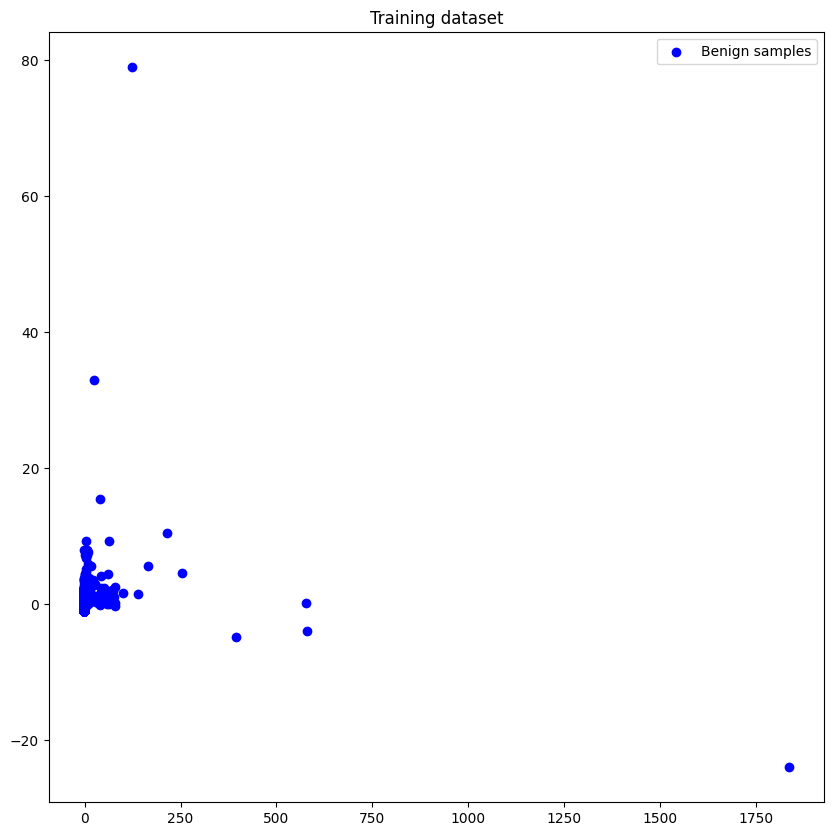

In [97]:
# Plot training dataset
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.figure(figsize=(10, 10))
plt.scatter(dataset_train_no_labels['PCA1'], dataset_train_no_labels['PCA2'], c='blue', label='Benign samples')
plt.title('Training dataset')

plt.legend(handler_map={plt.Line2D: HandlerPathCollection(update_func=update_legend_marker_size)})

plt.show()


In [98]:
# Testing phase

# Create a list of scores
scores = []
anomalias = []

correctos = 0
incorrectos = 0

correctos_quantile = 0
incorrectos_quantile = 0

for idx in dataset_test_no_labels.index:
    row = dataset_test_no_labels.loc[idx]
    print("Row: ", idx)
    print(dataset_test.loc[idx].to_dict())
    score = model.score_one(row.to_dict())
    #anomalo = model.classify(score)

    if score < 0:
        model.learn_one(row.to_dict())  # Aprende solo de datos benignos si lo deseas
    label = dataset_test.loc[idx, "Label"]
    print("Score: " + str(score) + " Label: " + str(label))
    # print("Anomalo: " + str(anomalo))
    # print(model.classify(score))
    if score > 0 and label == 1:
        correctos += 1
    elif score < 0 and label == 0:
        correctos += 1
    else:
        incorrectos += 1
    

    # if anomalo and label == 1:
    #     correctos_quantile += 1
    # elif not anomalo and label == 0:
    #     correctos_quantile += 1
    # else:
    #     incorrectos_quantile += 1
        
    scores.append(score)
    # anomalias.append(anomalo)


print("Correctos: ", correctos)
print("Incorrectos: ", incorrectos)
print(correctos/float((correctos+incorrectos)))

# print("Correctos Quantile: ", correctos_quantile)
# print("Incorrectos Quantile: ", incorrectos_quantile)
# print(correctos_quantile/float((correctos_quantile+incorrectos_quantile)))

Row:  0
{'PCA1': -0.3929218491485813, 'PCA2': 0.3463891574630696, 'Label': 0.0}
Score: -0.06315627187863426 Label: 0.0
Row:  1
{'PCA1': 0.3139868187972054, 'PCA2': 1.7266989729148128, 'Label': 1.0}
Score: -0.10900679665478163 Label: 1.0
Row:  2
{'PCA1': -1.527531079503063, 'PCA2': 0.4578075653710032, 'Label': 1.0}
Score: -0.17378542896540927 Label: 1.0
Row:  3
{'PCA1': 0.9039520041622467, 'PCA2': 2.13393696070427, 'Label': 1.0}
Score: -0.08773151577181992 Label: 1.0
Row:  4
{'PCA1': 0.8971556569749835, 'PCA2': 1.324264988403345, 'Label': 1.0}
Score: -0.024204931286601283 Label: 1.0
Row:  5
{'PCA1': -1.1666775637184483, 'PCA2': 0.3589602139216206, 'Label': 1.0}
Score: -0.13247101180211907 Label: 1.0
Row:  6
{'PCA1': 0.7500693418246405, 'PCA2': 0.8932576930963234, 'Label': 0.0}
Score: -0.0033347078956647014 Label: 0.0
Row:  7
{'PCA1': 0.372280623919639, 'PCA2': 2.069765498648402, 'Label': 1.0}
Score: -0.1290803864016985 Label: 1.0
Row:  8
{'PCA1': -1.7952658982802547, 'PCA2': -0.60187190

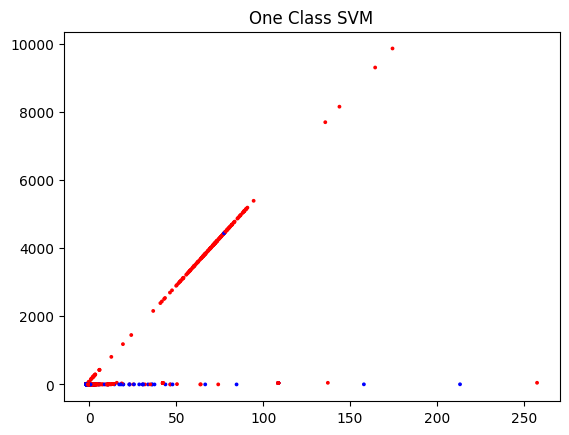

In [99]:
# # Convert dataframe to numoy array
dataset_test = dataset_test.to_numpy()

colors = []

for score in scores:
    if score > 0:
        colors.append('red')
    else:
        colors.append('blue')

# for anomalo in anomalias:
#     if anomalo:
#         colors.append('red')
#     else:
#         colors.append('blue')

plt.scatter(dataset_test[:, 0], dataset_test[:, 1], color=colors, s=3.0, label="Data points")




plt.axis("tight")
plt.title("One Class SVM")
plt.show()


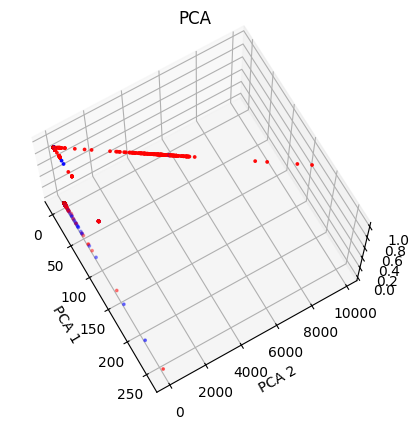

In [100]:
# Print in 3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_test[:, 0], dataset_test[:, 1], dataset_test[:, 2], color=colors, s=3.0)


# Cambia el punto de vista
ax.view_init(elev=70, azim=-30)

plt.title('PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()
